In [1]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")


In [3]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'
RAW_DATA_PATH

WindowsPath('c:/Users/Lyndon/Documents/University/CS3AM/coursework/CS3AM-COURSEWORK/data/01_raw')

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [5]:
sns.set_style('whitegrid')

In [6]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [7]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


ADF Statistic: -30.172921176758255
p-value: 0.0
Critical Values:
	1%: -3.4309413405870677
	5%: -2.8618013401241873
	10%: -2.5669091062250553


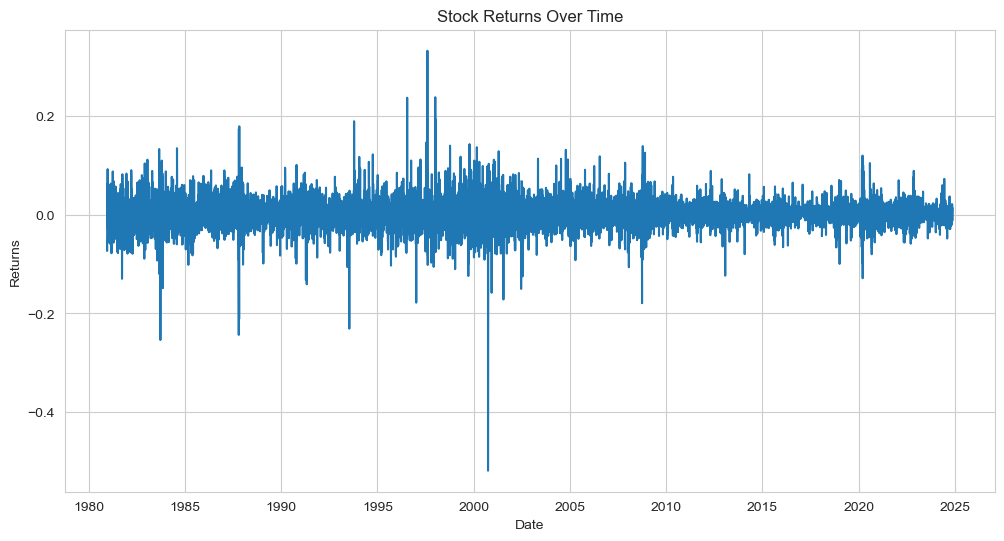

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select Returns as the target variable
df['Returns'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)
target = df['Returns']

# Check for stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(target)

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(target)
plt.title('Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# If not stationary, apply differencing
if adfuller(target)[1] > 0.05:
    target_diff = target.diff().dropna()
    adf_test(target_diff)
    plt.figure(figsize=(12, 6))
    plt.plot(target_diff)
    plt.title('Differenced Stock Returns')
    plt.show()
else:
    target_diff = target


In [9]:
train_size = int(len(target_diff) * 0.8)
train, test = target_diff[:train_size], target_diff[train_size:]

In [10]:
model = auto_arima(train, start_p=1, start_q=1, max_p=10, max_q=10,
                   seasonal=False, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True, stationary=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-37120.296, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-37120.306, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-37123.828, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-37124.143, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-37111.121, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-37127.709, Time=1.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-37125.101, Time=1.34 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-37136.399, Time=0.61 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-37140.556, Time=0.86 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-37138.216, Time=0.98 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-37139.282, Time=0.84 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-37141.257, Time=0.75 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=-37139.219, Time=2.64 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=-37137.257, Time=1.65 sec
 ARIM

In [11]:
# Make predictions on the test set
predictions = model.predict(n_periods=len(test))

# Calculate performance metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100
r2 = r2_score(test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

print(f'AIC: {model.aic()}')
print(f'BIC: {model.bic()}')


RMSE: 0.018040519071676624
MAE: 0.01251077476412733
MAPE: nan%
R²: 4.879090785059326e-05
AIC: -37141.256823964795
BIC: -37098.7223662579


In [12]:
# Generate in-sample predictions
in_sample_predictions = model.predict_in_sample()

# Generate out-of-sample forecasts with confidence intervals
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)


In [13]:
target.index[0]

Timestamp('1980-12-15 00:00:00')

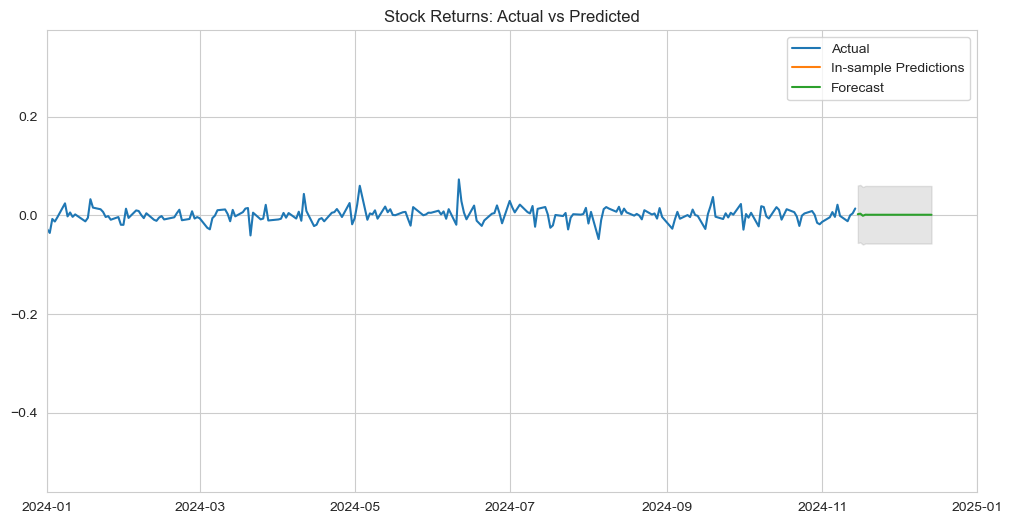

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(target_diff.index, target_diff, label='Actual')
plt.plot(target_diff.index[:len(in_sample_predictions)], in_sample_predictions, label='In-sample Predictions')
plt.plot(pd.date_range(start=target_diff.index[-1], periods=31, freq='D')[1:], forecast, label='Forecast')
plt.fill_between(pd.date_range(start=target_diff.index[-1], periods=31, freq='D')[1:],
                 conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2)
plt.title('Stock Returns: Actual vs Predicted')
plt.legend()
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2025-01-01'))
plt.show()